In [1]:
import os
import itertools

from scipy.io import arff
import pandas as pd
import numpy as np

from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score

import plotly.plotly as py
import plotly.graph_objs as go
from plotly.tools import set_credentials_file
from plotly.offline import init_notebook_mode
set_credentials_file(username='mynameistony', api_key='M37H9VmJFuqdvIdT33vj')
init_notebook_mode(connected=True)

import matplotlib.pyplot as mpl_plt

#### Part 1

Load data in .arff to pd.DataFrame (1.2)

In [2]:
data, _ = arff.loadarff('data/raw/spambase.arff.txt')

In [3]:
spambase = pd.DataFrame(data)

Drop columns (1.4)

In [4]:
spambase.drop(['capital_run_length_average', 'capital_run_length_longest', 'capital_run_length_total'], 1, inplace=True)

Convert column types (1.5)

In [5]:
def numberic_to_bool(df, inplace=False):
    """
    convert columns with numerical dtypes to boolean
    """
    if not inplace:
        df = df.copy()
    num_cols = df.select_dtypes(float).columns
    df.loc[:, num_cols] = df.loc[:, num_cols].astype(bool).astype(int)
    return df

def object_to_str(df, inplace=False, str_to_bool=False):
    """
    convert columns with objects dtypes to str (or bool)
    """
    if not inplace:
        df = df.copy()
    if not str_to_bool:
        lmbd = lambda x: x.str.decode('utf-8')
    else:
        lmbd = lambda x: x.str.decode("utf-8").astype(int)
    obj_cols = df.select_dtypes([np.object]).columns
    df.loc[:, obj_cols] = df.loc[:, obj_cols].apply(lmbd)
    return df

In [6]:
spambase = numberic_to_bool(spambase)

In [7]:
spambase = object_to_str(spambase, False, True)

Save data with bag of words (1.6)

In [8]:
spambase.to_csv('data/spambase_bag_of_words.csv', index=False)

#### Part 2 (unfinished)

Create labels (classes) to fit Naive Bayes (train and test sets in fact)

In [9]:
Y = spambase.pop('is_spam')
X = spambase

Fit Naive Bayes for Bernoulli destribution (because all columns are boolean now)

In [10]:
clf = BernoulliNB(fit_prior=False)
clf.fit(X, Y)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=False)

Predict for random sample

In [11]:
clf.predict(X.loc[5:6])

array([0, 1])

Compare execution time on whole dataset (4601 obs.) and sample (2000 obs.)

In [12]:
%%timeit
clf.fit(X.loc[:1999], Y[:2000])

1.99 ms ± 53.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [13]:
%%timeit
clf.fit(X, Y)

3.36 ms ± 65.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


#### Part 3

Load data in .arff to pd.DataFrame (3.1)

In [14]:
data, _ = arff.loadarff('data/raw/credit.arff.txt')

In [15]:
credit = pd.DataFrame(data)

Preprocessing

In [16]:
def str_to_cat(df, inplace=False, save_code_labels=True):
    """
    Convert str columns to categorical 
    """
    if not inplace:
        df = df.copy()
    if save_code_labels:
        code_labels = []
        
        def get_code_labels(series, storage_list):
            codes, labels = series.factorize()
            storage_list.append((series.name, dict(zip(set(codes), labels))))
            return codes
        
        lmbd = lambda x: get_code_labels(x, code_labels)
    else:
        lmbd = lambda x: x.astype('categorical').cat.codes
    obj_cols = df.select_dtypes([np.object]).columns
    df.loc[:, obj_cols] = df.loc[:, obj_cols].apply(lmbd)
    return df if not save_code_labels else df, code_labels

In [17]:
credit = object_to_str(credit)
credit, cat_labels = str_to_cat(credit)

Plot Age and Duration (3.2)

In [18]:
def age_duration_plt(df, age_column, duration_column):
    plt = [go.Scatter(x=credit.index, y=df[age_column], name='Age'), 
           go.Scatter(x=credit.index, y=df[duration_column], name='Duration')]
    return plt

In [19]:
plt = age_duration_plt(credit, 'Age', 'Duration')
py.iplot(plt)

Drop observations where Age < 0 (3.4)

In [20]:
credit = credit.loc[credit.Age > 0]

In [21]:
plt = age_duration_plt(credit, 'Age', 'Duration')
py.iplot(plt)

In [22]:
y = credit.pop('Approve')
X = credit

Check preprocessing if we have a binary classification

In [23]:
assert len(y.value_counts()) == 2

Split on train and test sets (3.5)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

Define built-in Decision Tree Classifier which is more advanced version of C4.5 algorithm (3.6)

In [25]:
model = DecisionTreeClassifier()

Train classifier and predict (3.7)

In [26]:
clf = model.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [27]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=mpl_plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    mpl_plt.imshow(cm, interpolation='nearest', cmap=cmap)
    mpl_plt.title(title)
    mpl_plt.colorbar()
    tick_marks = np.arange(len(classes))
    mpl_plt.xticks(tick_marks, classes, rotation=45)
    mpl_plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        mpl_plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    mpl_plt.tight_layout()
    mpl_plt.ylabel('True label')
    mpl_plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[57 21]
 [12 10]]


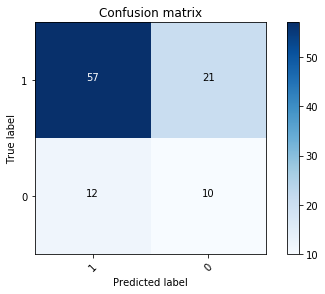

In [28]:
conf_matrix = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(conf_matrix, classes=[1,0], title='Confusion matrix')

Due to an unbalanced dataset, the best metric is ROC_AUC Curve (it will be much more accurate than accuracy)

In [29]:
print("ROC_AUC score: {:.4f}".format(roc_auc_score(y_test, y_pred)))
print("Accuracy score: {:.4f}".format(accuracy_score(y_test, y_pred)))

ROC_AUC score: 0.5927
Accuracy score: 0.6700


Print feature importances

In [30]:
def print_feature_importance(df, clf):
    importances = clf.feature_importances_
    indices = np.argsort(importances)[::-1]
    for f in range(X.shape[1]):
        print("{}. {} ({:.4f})".format(f + 1, df.columns[f], importances[indices[f]]))

In [31]:
print_feature_importance(X, clf)

1. CheckingAccount (0.1258)
2. Duration (0.1210)
3. CreditHistory (0.1122)
4. Purpose (0.1039)
5. CreditAmount (0.0974)
6. SavingsAccount (0.0646)
7. YearsEmployed (0.0529)
8. InstallmentRate (0.0466)
9. PersonalStatus (0.0438)
10. OtherDebtors (0.0419)
11. ResidentSince (0.0303)
12. Property (0.0265)
13. Age (0.0259)
14. OtherPlans (0.0244)
15. Housing (0.0188)
16. NumCreditsAtBank (0.0172)
17. Job (0.0146)
18. Dependents (0.0140)
19. Telephone (0.0108)
20. Foreign (0.0074)


Create decision tree graph and visualize it

In [32]:
graph_name = 'credit_decision_tree'
export_graphviz(clf, out_file='{}.dot'.format(graph_name)) # save graph in .dot format
os.system("dot -Tpng {}.dot -o {}.png".format(graph_name, graph_name)) # convert graph to png
os.remove("{}.dot".format(graph_name)) # remove .dot file
os.system("eog {}.png".format(graph_name)) # open graph

0